# Regresión logística

En esta libreta vamos a desarrollar los algoritmos de regresión logística, y vamos a aplicar los métodos a dos conjuntos de datos, uno donde se aplica directamente la regresión logística y otro donde se ejemplifica el uso de la regularización y los clasificadores polinomiales.

Igualmente vamos a probar el uso del descenso de gradiente, y el uso de herramientas de optimización que provienen de los paquetes de `scipy`.

In [100]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image  # Esto es para desplegar imágenes en la libreta
import sys


## 1. Función logística, función de costo y gradiente de la función de costo

La función logística está dada por 

$$
g(z) = \frac{1}{1 + e^{-z}},
$$

la cual tambien se conoce como función *probit* (probabilidad de un bit). La cual es importante que podamos calcular en forma vectorial. Si bien el calculo es de una sola linea, el uso de estas funciones auxiliares facilitan la legibilidad del código.

#### Ejercicio 1: Desarrolla la función logística, la cual se calcule para todos los elementos de un ndarray (20 puntos)

In [101]:
def logistica(z):
    """
    Calcula la función logística para cada elemento de z
    
    @param z: un ndarray
    @return: un ndarray de las mismas dimensiones que z
    """
    # Introduce código aqui (una linea de código)
    #---------------------------------------------------
    return 1/(1+np.exp(-z))
    #---------------------------------------------------
    
# prueba que efectivamente funciona la función implementada
# si el assert es falso regresa un error de aserción (el testunit de los pobres)
assert (np.abs(logistica(np.array([-1, 0, 1])) - np.array([ 0.26894142, 0.5, 0.73105858]))).sum() < 1e-6


Para probar la función vamos a graficar la función logística en el intervalo [-5, 5]

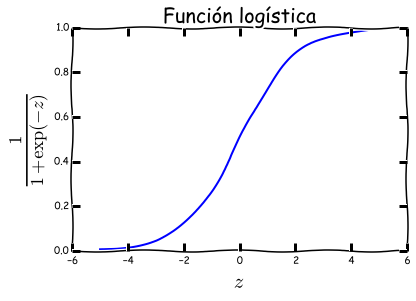

In [102]:
z = np.linspace(-5, 5, 100)
with plt.xkcd():
    plt.plot( z, logistica(z))
    plt.title(u'Función logística', fontsize=20)
    plt.xlabel(r'$z$', fontsize=20)
    plt.ylabel(r'$\frac{1}{1 + \exp(-z)}$', fontsize=26)


Una vez establecida la función logística, vamos a implementar la función de costo *sin regularizar* para la regresión logística, la cual está dada por

$$
J(\omega) = -\frac{1}{T} \sum_{i=1}^T \left[ y^{(i)}\log(h_\omega(x^{(i)}) + (1 - y^{(i)})\log(1 - h_\omega(x^{(i)}))\right],
$$

donde 

$$
h_\omega(x^{(i)}) = g(\omega^T x_e^{(i)}),
$$

las cuales fueron ecuaciones revisadas en clase.

#### Ejercicio 2: Implementa la función de costo para un conjunto de aprendizaje (20 puntos)

In [103]:
def costo(w, x, y):
    """
    Calcula el costo de una w dada para el conjunto dee entrenamiento dado por y y x
    
    @param w: un ndarray de dimensión (n + 1, 1) 
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    
    @return: un flotante con el costo
    
    """ 
   
    #T= num de renglones de la matriz X
    T = x.shape[0]
    
    #L sera un vector que será la logistica de cada elemento del vector que resulta al multiplicar el producto punto de la
    #matriz x por el vector w
    L=logistica(x.dot(w))
    #LogL será un vector que se calculará obteniendo la funcion logistica de cada elemento del vector L
    LogL=np.log(L)
    #calculamos el producto punto del vector transpuesta de -Y y lo multiplicamos por el vector LogL y el resultado será un
    #valor real que llamaremos "C"
    c=(-y.T.dot(LogL))
    #formaremos un nuevo vector llamada nueva_y que se calcula restandole al 1 cada valor del vector y
    nueva_y=1.0-y
    #tenemos un nuevo vector llamado a que será el vector transpuesto del vector nueva_y
    a=nueva_y.T
    #formamos una nueva matriz en donde al numero 1 le quitamos cada cada elemento de la matriz L
    nueva_L=1.0-L
    #calculamos un nuevo vector b obteniendo el logaritmo de cada elemento del vector nueva_L
    b=np.log(nueva_L)
    #calculamos el producto punto del vector a por el vector b y lo guardamos en d, en donde d es un numero real
    d=a.dot(b)
    #por ultimo calculamos el costo de la siguiente manera:
    costo=(c-d)/T
    return costo    
    
   

    
# Otra vez el testunit del pobre (ya lo calcule yo, pero puedes hacerlo a mano para estar seguro)
w = np.ones((2,1))

x = np.array([[1, 10],
              [1, -5]])

y1 = np.array([[1],
               [0]])

y2 = np.array([[0],
               [1]])

y3 = np.array([[0],
               [0]])

y4 = np.array([[1],
               [1]])

#print abs(costo(w, x, y1) - 0.01)
#print abs(costo(w, x, y2) - 0.01)
#print abs(costo(w, x, y3) - 0.01)
#print abs(costo(w, x, y4) - 0.01)

#print costo(w, x, y1)
#assert abs(costo(w, x, y1) - 0.01)< 1e-2
#assert abs(costo(w, x, y2) - 7.5) < 1e-2
#assert abs(costo(w, x, y3) - 5.5) < 1e-2
#assert abs(costo(w, x, y4) - 2.0) < 1e-2

De la misma manera, para poder implementar las funciones de aprendizaje, vamos a implementar el gradiente de la función de costo. El gradiente de la función de costo respecto a $\omega$ es (como lo vimos en clase) el siguiente:

$$
\frac{\partial J(\omega)}{\partial \omega_j} = -\frac{1}{T} \sum_{i=1}^T (y^{(i)} - h_\omega(x^{(i)})x_j^{(i)} 
$$

y a partir de las ecuaciones individuales de puede obtener $\nabla J(\omega)$, la cual no la vamos a escribir en la libreta para que revisen en sus notas como se puede resolver este problema en forma matricial. Si bien para el descenso de gradiente podemos utilizar directamente el gradiente negado, al implementar métodos de optimización avanzados, necesitamos que el gradiente sea efectivamente el gradiente.

#### Ejercicio 3: Implementa (con operaciones matriciales) la función del gradiente (20 puntos)

In [104]:
def gradiente(w, x, y):
    """
    Calcula el gradiente del costo de la regrasión logística, para una theta, conociendo un conjunto de aprendizaje.
    
    @param w: un ndarray de dimensión (n + 1, 1) 
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    
    @return: un ndarray de mismas dimensiones que w
    
    """
    T = x.shape[0]

    #------------------------------------------------------------------------
    
    L=logistica(x.dot(w))
    Lnueva=y-L
    x_nueva= x.T.dot(Lnueva)
    
    gradiente=(-1.0)*(x_nueva)/T
    return gradiente


    
    
    #------------------------------------------------------------------------
    
# Otra vez el testunit del pobre (ya lo calcule yo, pero puedes hacerlo a mano para estar seguro)
w = np.ones((2, 1))

x = np.array([[1, 10],
              [1, -5]])

y1 = np.array([[1],
               [0]])

y2 = np.array([[0],
               [1]])

y3 = np.array([[0],
               [0]])

y4 = np.array([[1],
               [1]])

assert abs(0.00898475 - gradiente(w, x, y1)[0]) < 1e-4
assert abs(7.45495097 - gradiente(w, x, y2)[1]) < 1e-4 
assert abs(4.95495097 - gradiente(w, x, y3)[1]) < 1e-4 
assert abs(-0.49101525 - gradiente(w, x, y4)[0]) < 1e-4 
#exit()

## 2. Descenso de gradiente y el método BGFS para regresión logística

Ahora vamos a desarrollar las funciones necesarias para realizar el entrenamiento y encontrar la mejor $\omega$ de acuero a la función de costos y un conjunto de datos de aprendizaje.

Para este problema, vamos a utilizar una base de datos sintética proveniente del curso de Andrew Ng que se encuentra en coursera. Supongamos que pertenecemos al departamente de servicios escolares de la UNISON y vamos a modificar el procedimiento de admisión, y en lugar de utilizar un solo exámen (EXCOBA) y la información del cardex de la preparatoria, hemos decidido aplicar dos exámenes, uno sicométrico y otro de habilidades estudiantiles. Dichos exámenes se han aplicado el último año aunque no fueron utilizados como criterio. Así, tenemos un historial entre estudiantes aceptados y resultados de los dos exámenes. El objetivo es hacer un método de regresión que nos permita hacer la admisión a la UNISON tomando en cuenta únicamente los dos exámenes y simplificar el proceso. *Recuerda que esto no es verdad, es solo un ejercicio*.

Bien, los datos se encuentran en el archivo `admision.txt` el cual se encuentra en formato `cvs` (osea los valores de las columnas separados por comas. Vamos a utilizar el mismo método para cargar datos que el que utilizamos para regresión lineal, y vamos a graficar la información para entender un poco los datos.

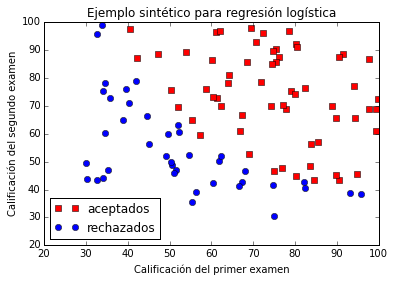

In [105]:
datos = np.loadtxt('admision.txt', comments='%', delimiter=',')

x, y = datos[:,0:-1], datos[:,-1:] 
x = np.c_[np.ones((x.shape[0], 1)), x]

plt.plot(x[y.ravel() == 1, 1], x[y.ravel() == 1, 2], 'sr', label='aceptados') 
plt.plot(x[y.ravel() == 0, 1], x[y.ravel() == 0, 2], 'ob', label='rechazados')
plt.title(u'Ejemplo sintético para regresión logística')
plt.xlabel(u'Calificación del primer examen')
plt.ylabel(u'Calificación del segundo examen')
plt.axis([20, 100, 20, 100])
plt.legend(loc=0)
#sys.exit()


Vistos los datos un clasificador lineal podría ser una buena solución. 

Ahora vamos a implementar el método de descenso de gradiente, casi de la misma manera que lo implementamos para regresión lineal (por lotes)

#### Ejercicio 4: Implementa el descenso de gradiente para el problema de regresión logística en modo batch (20 puntos)

In [106]:
def descenso_rl_lotes(x, y, alpha, epsilon=1e-4, max_iter=int(1e4), costos=False):
    """
    Descenso de gradiente por lotes para resolver el problema de regresión logística con un conjunto de aprendizaje

    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos
    @param y: un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    @param alpha: Un flotante (típicamente pequeño) con la tasa de aprendizaje
    @param epsilon: Un flotante pequeño como criterio de paro. Por default 1e-4
    @param max_iter: Máximo numero de iteraciones. Por default 1e4
    @param costos: Un booleano para saber si calculamos el historial de costos o no
    
    @return: w, costo_hist donde costo es ndarray de dimensión (n + 1, 1) y costo_hist es un
             ndarray de dimensión (max_iter,) con el costo en cada iteración si costos == True, si no
             regresa None
             
    """
    
    T, n = x.shape[0], x.shape[1] - 1
    
    w = np.zeros((n + 1, 1))
    costo_hist = np.zeros(max_iter) if costos else None
    
    for iter in xrange(max_iter):
       
    #--------------------------------------------------------------
        # Agregar aqui tu código
        #
        # Recuerda utilizar las funciones que ya has 
        #se calcula el gradiente
        g = gradiente(w,x,y)
        #se va modificando el vector w de la siguiente manera
        w += -alpha * g
        #se obtiene el max num del vector w y si es menor que epsilon se regresa ese valor y termina la funcion
        if np.max(np.abs(w))<epsilon:
            return w,costo_hist   
        if costos:
            costo_hist[iter] = costo(w, x, y)
        
        
            
    return w, costo_hist


Para probar la función de aprendizaje, vamos a aplicarla a nuestro problema de admisión. Primero recuerda que tienes que hacer una exploración para encontrar el mejor valor de $\alpha$. Así que utiliza el código de abajo para ajustar $\alpha$.

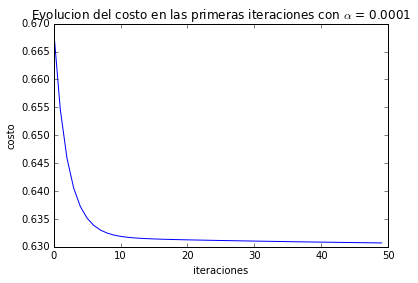

In [107]:
alpha = 1e-4
mi = 50
_, costo_hist = descenso_rl_lotes(x, y, alpha, epsilon=1e-4, max_iter=mi, costos=True)

plt.plot(np.arange(mi), costo_hist)
plt.title(r'Evolucion del costo en las primeras iteraciones con $\alpha$ = ' + str(alpha))
plt.xlabel('iteraciones')
plt.ylabel('costo')


Una vez encontrada la mejor $\alpha$, entonces podemos calcular $\omega$ (esto va a tardar bastante), recuerda que el costo final debe de ser lo más cercano a 0 posible, así que agrega cuantas iteraciones sean necesarias: 

In [108]:
w_lotes, _ = descenso_rl_lotes(x, y, alpha, max_iter = int(1e6))
print w_lotes
print costo(w_lotes, x, y)

[[-4.81178575]
 [ 0.04528053]
 [ 0.03819138]]
[[ 0.38739001]]


Es interesante ver como el descenso de gradiente no es eficiente en este tipo de problemas, a pesar de ser problemas de optimización convexos.

Bueno, este método nos devuelve $\omega$, pero esto no es suficiente para ecir que tenemos un clasificador, ya que un método de clasificación se compone de dos métodos, uno para **aprender** y otro para **predecir**. Recuerda que para realizar la predicción con el método de regrasión lineal y el criterio MAP, no es necesario calcular la regrasión logística completa (lo que hace un método de predicción más rápido).

#### Ejercicio 5: Desarrolla una función de predicción (20 puntos)

In [109]:
def predictor(w, x):
    """
    Predice los valores de y_hat (que solo pueden ser 0 o 1), utilizando el criterio MAP.
    
    @param w: un ndarray de dimensión (n + 1, 1)
    @param x: un ndarray de dimensión (T, n + 1) donde la primer columna son puros unos

    @return: y_hat un ndarray de dimensión (T, 1) donde cada entrada es 1.0 o 0.0
    """
    #-------------------------------------------------------------------------------------
    
    
    #va a checar todo el vector de x.dot(w) si un elemento es mayor que 0 entonces se guardara 1 sino se guarda 0 en el
    #vector y_estimada
    dato=x.dot(w)
    print "dato:",dato
    
    y_estimada = np.where(x.dot(w)>0,1,0)
    return y_estimada 
    
    
    
    #--------------------------------------------------------------------------------------

    

¿Que tan bueno es este clasificador? ¿Es que implementamos bien el método?

Vamos a contestar esto por partes. Primero, vamos a graficar los mismos datos pero vamos a agregar la superficie de separación, la cual en este caso sabemos que es una linea recta. Como sabemos el criterio para decidir si un punto pertenece a la clase 1 o cero es si el valor de $\omega^T x_e^{(i)} \ge 0$, por lo que la frontera entre la región donde se escoge una clase de otra se encuentra en:

$$
0 = \omega_0 + \omega_1 x_1  + \omega_2 x_2,
$$

y despejando:

$$
x_2 = -\frac{\omega_0}{\omega_2} -\frac{\omega_1}{\omega_2}x_1
$$

son los pares $(x_1, x_2)$ de valores en la forntera. Al ser estos (en este caso) una linea recta solo necesitamos dos para graficar la superficie de separación. 


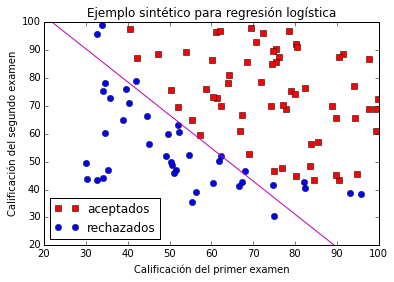

In [110]:
x1_frontera = np.array([20, 100]) #Los valores mínimo y máximo que tenemos en la gráfica de puntos
x2_frontera = -(w_lotes[0] / w_lotes[2]) - (w_lotes[1] / w_lotes[2]) * x1_frontera

plt.plot(x[y.ravel() == 1, 1], x[y.ravel() == 1, 2], 'sr', label='aceptados') 
plt.plot(x[y.ravel() == 0, 1], x[y.ravel() == 0, 2], 'ob', label='rechazados')
plt.plot(x1_frontera, x2_frontera, 'm')
plt.title(u'Ejemplo sintético para regresión logística')
plt.xlabel(u'Calificación del primer examen')
plt.ylabel(u'Calificación del segundo examen')
plt.axis([20, 100, 20, 100])
plt.legend(loc=0)



Y para que tengas una idea de lo que debería de salir, anexo una figura obtenida con el código que yo hice:

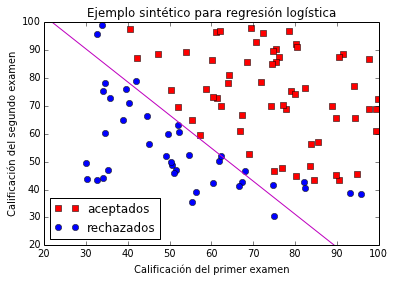

In [111]:
Image(filename='ejemplo_logistica_1.png')

Bueno, ya vimos que el método del descenso de gradiente, si bien es correcto y fácil de implementar, es bastante ineficiente en cuanto a tiempo (inclusive para un problema bastante simple, por lo que vamos a utilizar la función `minimize`que provee `scipy` la que vamos a utilizar con el algoritmo BFGS (explicado en clase en forma somera). Ejecuta la celda de abajo para revisar la documentación de `minimize` 

In [112]:
from scipy.optimize import minimize

#minimize?

Como puedes ver, el método BFGS es el método por default. Los parámetros que hay que agregar son:

* Una $\omega$ inicial en `x0`
* Una funcion de costo $J(\omega)$ en `fun`
* Una función de gradiente $\nabla J(\omega)$ en `jac`
* Argumentos extras para `fun` y `jac` en forma de tupla
* Opciones del método de optimización en `options` como un diccionario. Las opciones pueden ser:
  * gtol: Valor de tolerancia en la variación de la norma del gradiente
  * maxiter: Máximo numero de iteraciones
  * disp: Si True, despliega la información sobre la convergencia del algoritmo

La función regresa un objeto resultado `res`, del cual solo nos interesa `res.x`, el resultado de theta.

Como $\omega$ en este método debe de ser un ndim de una sola dimensión, y nosotros hemos estado usando $\theta$ como un vector columna pues podemos modificar un poco estas funciones con unas nuevas (esto de hecho es posible hacerlo modificando las funciones originales, pero podría causar mas problemas de conceptos hacerlo). De hecho una vez funcionando, un buen científica de la computación (o un buen desarrollador) aplicaría una etapa de *refactoring*, esto es, modificar todo lo que obscurece y hace menos ineficiente, o menos estético el código.

Veras que si lo corres varias veces, en muchas ocasiones vamos a tener que el resultado no se pudo lograr por falta de precisión en la función del gradiente. Esto es debido a la forma en que estamos calculando el gradiente, y a que si la solución inicial realiza una partición pésima del estado, entonces hay problemas para estimar el inverso del hessiano, por problemas de estabilidad numérica del método. Por esta razón se inicializa el algoritmo con un valor de $\omega$ obtenido en forma aleatoria (valores pequeños).

Lo interesante es que el algoritmo avisa cuando no hay convergencia, y vuando hay se obtiene en muy pocas iteraciones (19 en promedio)  

In [113]:
w0 = 1e-2 * np.random.rand(x.shape[1])

funcion = lambda w, x, y: costo(w.reshape(-1,1), x, y)
jacobiano = lambda w, x, y: gradiente(w.reshape(-1,1), x, y).ravel()
res = minimize(x0=w0,
               fun=funcion,
               jac=jacobiano,
               args = (x, y),
               method='BFGS',
               options= {'maxiter': 400, 'disp': True})
print res

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27
   status: 0
  success: True
     njev: 27
     nfev: 27
 hess_inv: array([[  3.24722516e+03,  -2.61229406e+01,  -2.62442377e+01],
       [ -2.61229406e+01,   2.24682504e-01,   1.97652993e-01],
       [ -2.62442377e+01,   1.97652993e-01,   2.28355986e-01]])
      fun: 0.2034977015894626
        x: array([-25.1613379 ,   0.20623173,   0.20147164])
  message: 'Optimization terminated successfully.'
      jac: array([ -4.62500632e-08,  -3.18982197e-06,  -2.40326769e-06])


C:\Users\jesus\Anaconda\lib\site-packages\IPython\kernel\__main__.py:10: RuntimeWarning: overflow encountered in exp
C:\Users\jesus\Anaconda\lib\site-packages\IPython\kernel\__main__.py:20: RuntimeWarning: divide by zero encountered in log


Otra forma de obtener el resltado es utilizando un método tipo *simplex* que no necesita calcular ni el jacobiano, ni la inversión del hessiano. Que si bien requiere sensiblemente de más iteraciones, para un problema relativamente simple como este es suficiente (sin embargo para problemas de regresión lineal con muchos atributos, o redes neuronales, ya no será suficiente).

In [114]:
w0 = np.zeros(x.shape[1])

funcion = lambda w, x, y: costo(w.reshape(-1,1), x, y)
jacobiano = lambda w, x, y: gradiente(w.reshape(-1,1), x, y).ravel()
res = minimize(x0=w0,
               fun=funcion,
               args = (x, y),
               method='Nelder-Mead',
               options= {'maxiter': 400, 'disp': True})
print res

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287
  status: 0
    nfev: 287
 success: True
     fun: 0.20349770159021513
       x: array([-25.16130062,   0.20623142,   0.20147143])
 message: 'Optimization terminated successfully.'
     nit: 157


Y ahora veamos la partición del espacio con este método, la cual es ligeramente diferente a la obtenida con el descenso de gradiente:

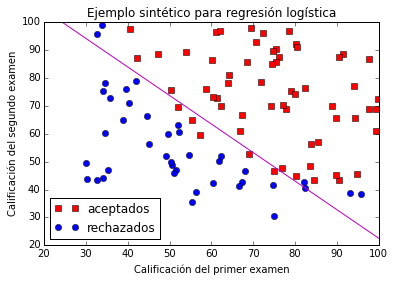

In [115]:
w_NM = res.x.reshape(-1,1)

x1_frontera = np.array([20, 100]) #Los valores mínimo y máximo que tenemos en la gráfica de puntos
x2_frontera = -(w_NM[0] / w_NM[2]) - (w_NM[1] / w_NM[2]) * x1_frontera

plt.plot(x[y.ravel() == 1, 1], x[y.ravel() == 1, 2], 'sr', label='aceptados') 
plt.plot(x[y.ravel() == 0, 1], x[y.ravel() == 0, 2], 'ob', label='rechazados')
plt.plot(x1_frontera, x2_frontera, 'm')
plt.title(u'Ejemplo sintético para regresión logística')
plt.xlabel(u'Calificación del primer examen')
plt.ylabel(u'Calificación del segundo examen')
plt.axis([20, 100, 20, 100])
plt.legend(loc=0)
